<H1> EL-3019 : Prédiction des ventes chez Walmart </H1>


Le problème considéré ici est bâti à partir d'une compétion Kaggle, https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting
où il s'agissait de prévoir les ventes dans les différents départements des 45 magasins Walmart des Etats-Unis. 
Le problème a été simplifié ici en regroupant les ventes des différents départements pour ne s'intéresser qu'aux ventes globales des magasins. Certaines données ont été modifiées pour les besoins de la cause, et pour distinguer ce jeu de données et les résultats associés de travaux précédents éventuellement disponibles ça et là. 

Votre objectif sera donc de prédire les ventes des différents magasins, à partir d'un historique sur 3 années comprenant :

- fichier data_w.csv
    - 'Store':  numéro du magasin
    - 'Date' : date (semaine considérée)
    - 'Weekly_Sales' : ventes de la semaine (en \$)
    - 'Temperature' : température (en K)
    - 'Fuel_Price' : prix du carburant (en \$)
    - 'Markdown' : valeur moyenne des campagnes publicitaires (unité arbitraire)
    - 'CPI' : [Consumer Price Index](https://www.bls.gov/cpi/)
    - 'Unemployment' : taux de chomage
    - 'IsHoliday' : période de vacances (Vrai/faux)

- fichier stores_w.csv
    - 'Store' : numéro du magasin
    - 'Type' : type de magasin
    - 'Size' : surface
    - 'People' : nombre d'employés

In [1]:
import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
SEED = 169

KernelInterrupted: Execution interrupted by the Jupyter kernel.

KernelInterrupted: Execution interrupted by the Jupyter kernel.

## 1 - Lecture des fichiers

Importer les fichiers `data_w.csv`  et `stores_w.csv`  



In [2]:
data =  pd.read_csv('data_w.csv')
stores =  pd.read_csv('stores_w.csv')

> 1.1 Combien d'exemples contient `data`  ? Combien de magasins sont-ils répertoriés dans stores ?

In [3]:
print(f"Il y a {data.shape[0]} lignes")

Il y a 6438 lignes


In [4]:
print(f"Il y a {stores['Store'].unique().shape[0]}")

Il y a 45


> 1.2 Quelle était la température la semaine du '2012-09-28' pour le magasin n°11 ? (Question non bloquante - si vous n'y arrivez pas, passez)

In [5]:
data_per_date = data[data['Date'] == '2012-09-28']
shop_11_temp = data_per_date[data_per_date['Store'] == 11]['Temperature']
print(f"La température est {shop_11_temp.values[0]}°K pour le '2012-09-28' au magasin n°11.")

La température est 77.67°K pour le '2012-09-28' au magasin n°11.


## 2 - Combinaison des données


On dispose donc à la fois d'une table `data` qui contient les ventes hebdomadaires et les conditions particulières pour les magasins, et d'une table `stores` qui contient des caractéristiques des magasins. 

>2.1 On souhaite alors combiner ces deux tables en une nouvelle table qui contiendra l'ensemble des données. Quelle fonction utiliser pour cela  : pd.merge, pd.concat, pd.append ? 

La méthode à utliser est merge(), car on souhaite fuisionner les tables sur une certaine donnée.

> 2.2 Effectuez cette opération de regroupement, et nommez `df` le tableau résultant. 

> Si vous n'y arriviez pas, chargez le fichier `df_w.csv` 

In [6]:
df = pd.merge(data, stores, on=['Store'])

In [7]:
df.head()

Store        Date  Weekly_Sales  Temperature  Fuel_Price         CPI  \
0      1  2010-02-05    1643690.90        42.31       2.572  211.096358   
1      1  2010-02-12    1641957.44        38.51       2.548  211.242170   
2      1  2010-02-19    1611968.17        39.93       2.514  211.289143   
3      1  2010-02-26    1409727.59        46.63       2.561  211.319643   
4      1  2010-03-05    1554806.68        46.50       2.625  211.350143   

   Unemployment  IsHoliday  Markdown Type    Size  People  
0         8.106      False       0.0    A  151315    40.0  
1         8.106       True       0.0    A  151315    40.0  
2         8.106      False       0.0    A  151315    40.0  
3         8.106      False       0.0    A  151315    40.0  
4         8.106      False       0.0    A  151315    40.0

In [8]:
df.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment', 'IsHoliday', 'Markdown', 'Type', 'Size', 'People'],
      dtype='object')

## 3 - Analyse rapide


> 3.1 Quel est le nombre de lignes de `df` ? Son nombre de colonnes ?

In [9]:
print("Le nombre de ligne est {} et le nombre de colonne est {}".format(df.shape[0], df.shape[1]))

Le nombre de ligne est 6438 et le nombre de colonne est 12


> 3.2 Existe-t-il des lignes dupliquées (méthode `duplicated`) ; dans l'affirmative combien ? Dans l'affirmative toujours, suprimez les (méthode `drop_duplicates`) et vérifiez que c'est bien le cas dans le tableau résultant

In [10]:
df[df.duplicated(keep=False)]

Store        Date  Weekly_Sales  Temperature  Fuel_Price         CPI  \
15        1  2010-05-21    1399662.07        76.44       2.826  210.617093   
16        1  2010-05-21    1399662.07        76.44       2.826  210.617093   
4933     35  2011-06-10     855130.21        73.26       3.881  138.860638   
4934     35  2011-06-10     855130.21        73.26       3.881  138.860638   
4935     35  2011-06-10     855130.21        73.26       3.881  138.860638   

      Unemployment  IsHoliday  Markdown Type    Size  People  
15           7.808      False       0.0    A  151315    40.0  
16           7.808      False       0.0    A  151315    40.0  
4933         8.512      False       0.0    B  103681    44.0  
4934         8.512      False       0.0    B  103681    44.0  
4935         8.512      False       0.0    B  103681    44.0

In [11]:
print("Il y a 2 lignes qui sont dupliquées, certaines plusieurs fois.")

Il y a 2 lignes qui sont dupliquées, certaines plusieurs fois.


In [12]:
df = df.drop_duplicates()
df[df.duplicated(keep=False)].sum().sum()

0.0

> 3.3 Quels sont les types des colonnes `Date`, `Temperature`, `IsHoliday` et `Size` ?


In [13]:
df.dtypes

Store             int64
Date             object
Weekly_Sales    float64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
IsHoliday          bool
Markdown        float64
Type             object
Size              int64
People          float64
dtype: object

> 3.4 Existe-t-il des données manquantes ; dans l'affirmative combien ? 

In [14]:
df.isna().sum()

Store           0
Date            0
Weekly_Sales    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
IsHoliday       0
Markdown        0
Type            0
Size            0
People          0
dtype: int64

In [15]:
print("Il n'y a pas de données manquantes")

Il n'y a pas de données manquantes


> 3.5 Quelles sont les natures des différentes variables ? Quantitative, qualitative, ordinale ?  Cocher (mettre une croix dans les "cases" adéquates)
ex : 
- Couleur : : [ ] quantitative [x] qualitative [ ] ordinale  

> - 'Store' : [ ] quantitative [X] qualitative [ ] ordinale  
> - 'Date' : [ ] quantitative [ ] qualitative [X] ordinale  
> - 'Weekly_Sales' : [X] quantitative [ ] qualitative [ ] ordinale  
> - 'Temperature' : [X] quantitative [ ] qualitative [ ] ordinale  
> - 'Fuel_Price' : [X] quantitative [ ] qualitative [ ] ordinale  
> - 'CPI' : [X] quantitative [ ] qualitative [ ] ordinale  
> - 'Unemployment' : [X] quantitative [ ] qualitative [ ] ordinale  
> - 'IsHoliday' : [ ] quantitative [X] qualitative [ ] ordinale  
> - 'Type' : [ ] quantitative [X] qualitative [ ] ordinale  
> - 'Size' : [X] quantitative [ ] qualitative [ ] ordinale  

La variable `Date`  est bien évidemment une variable de type date.. qui n'est pas forcément reconnue comme cela. Exécuter la ligne suivante pour forcer le type

In [16]:
df['Date'] = df['Date'].apply(pd.to_datetime)

## 4 - Valeurs manquantes

La fonction suivante va permettre, pour les besoins du sujet, d'ajouter quelques valeurs manquantes 

In [17]:
def addNans(df,nbNans, seed=None):
    # Randomly adds (less than) nbNans nans in df
    nx,ny = df.shape
    np.random.seed(seed)
    df2=df.copy()
    for k in range(nbNans):
        df2.iloc[np.random.randint(0,high=nx, size=1), 
                         np.random.randint(0, high=ny, size=1)] = np.nan
    return df2

In [18]:
df2 = addNans(df,55, seed=SEED)

nans = pd.isnull(df2).to_numpy().nonzero()
nan1 = nans[0][0], nans[1][0]
nan2 = nans[0][1], nans[1][1]
nan3 = nans[0][2], nans[1][2]

print(df.iloc[nan1], df.iloc[nan2], df.iloc[nan3])

3.353 151315 False


### 4.1 Nombre de NaN

> 4.1 Combien `df2` contient-il de NaN au total ?  Combien contient-il de NaN dans la colonne `Temperature`, dans la colonne `Type` ?

In [19]:
isn = df2.isna().sum()
print("Il y a {} 'NaN' dans 'Temperature' et {} dans 'Type'".format(isn['Temperature'], isn['Type']))
print("Il y a en tout {} 'NaN'".format(isn.sum()))

Il y a 1 'NaN' dans 'Temperature' et 4 dans 'Type'
Il y a en tout 55 'NaN'


In [20]:
# Position des nans (pour le test qui suit)
nans = pd.isnull(df2).to_numpy().nonzero()
nan1 = nans[0][0], nans[1][0]
nan2 = nans[0][1], nans[1][1]
nan3 = nans[0][2], nans[1][2]

In [21]:
print(df.iloc[nan1], df.iloc[nan2], df.iloc[nan3])

3.353 151315 False


### 4.2 Imputation 

Vous allez imputer ces valeurs manquantes en utilisant d'une part la méthode `fillna` de pandas, d'autre part une imputation par KNN. 
L'imputation par kNN de sklearn ne fonctionne pas (actuellement) pour les données non numériques. Vous remplacerez donc les données catégorielles en utilisant la méthode `fillna` (avec l'option "ffill") et les données `quantitatives` par kNN. 

> La méthode d’imputation par les K-plus proches voisins est réalisée par une classe qui fonctionne de manière analogue à celle vue pour l’imputation par une valeur unique. La méthode KNNImputer fonctionne aussi en trois étapes + on déclare le modèle ; il s’agit de la fonction KNNImputer dans laquelle on assigne le nombre de K plus proches voisins (appel à un constructeur) + … puis on effectue l’estimation + ….puis on impute les données manquantes dans la dataFrame. Le script suivant réalise une imputation avec les 5 plus proches voisins

In [22]:
quali = ["Store","IsHoliday","Type"]
quanti = ["Weekly_Sales","Temperature","Fuel_Price","CPI","Unemployment","Markdown", "Size", "People"]

### 4.2.1 Variables qualitatives

In [23]:
df2[quali] = df2[quali].fillna(method='ffill')

In [24]:
print(df2[quali].isna().sum())

Store        0
IsHoliday    0
Type         0
dtype: int64


### 4.2.2 Variables quantitatives

In [25]:
DeepnoteChart(df2, """{"layer":[{"layer":[{"mark":{"clip":true,"type":"bar","tooltip":true},"encoding":{"x":{"sort":null,"type":"quantitative","field":"Temperature","scale":{"type":"linear"},"format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"},"y":{"sort":null,"type":"quantitative","scale":{"type":"linear"},"format":{"type":"default","decimals":null},"aggregate":"count","formatType":"numberFormatFromNumberType"},"color":{"sort":null,"type":"quantitative","field":"Temperature","scale":{"scheme":"purples"},"aggregate":"sum"}}}]}],"title":"","config":{"legend":{}},"$schema":"https://vega.github.io/schema/vega-lite/v5.json","encoding":{}}""")

**Normalisation.** On doit commencer par normaliser les données avant d'utiliser une technique de type KNN. Pour cela, importez `StandardScaler` et mettez le en oeuvre pour mettre à jour `df2[quanti]`

In [26]:
from sklearn.preprocessing import StandardScaler

In [27]:
sc = StandardScaler()
sc.fit(df2[quanti])
df2[quanti] = sc.transform(df2[quanti])

In [28]:
DeepnoteChart(df2, """{"layer":[{"layer":[{"mark":{"clip":true,"type":"bar","tooltip":true},"encoding":{"x":{"sort":null,"type":"quantitative","field":"Temperature","scale":{"type":"linear"},"format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"},"y":{"sort":null,"type":"quantitative","scale":{"type":"linear"},"format":{"type":"default","decimals":null},"aggregate":"count","formatType":"numberFormatFromNumberType"},"color":{"sort":null,"type":"quantitative","field":"Temperature","scale":{"scheme":"blues"}}}}]}],"title":"","config":{"legend":{}},"$schema":"https://vega.github.io/schema/vega-lite/v5.json","encoding":{}}""")

> 4.2 Quelle est la valeur trouvée, après normalisation, à la position [1227, 'Temperature'] ?

In [29]:
df2.loc[1227, 'Temperature']

1.5541125913898075

> 4.3 Quelle est la valeur trouvée, après normalisation, à la position [2134, 'CPI'] ?

In [30]:
df2.loc[2134, 'CPI']

-0.8494303607616269


**Remarque.** Pour des questions d'interprétation des résultats et analyse des graphiques, on reviendra ci-dessous à la représentation initiale par `sc.inverse_transform`. Il pourra éventuellement être utile, si la méthode que vous utiliserez le requiert, de refaire une normalisation. 

**Imputation**

In [31]:
from sklearn.impute import KNNImputer

In [32]:
impute = KNNImputer(missing_values = np.nan ,n_neighbors = 5)

In [33]:
impute.fit(df2[quanti])
df2[quanti] = impute.transform(df2[quanti])
df2[quanti] = sc.inverse_transform(df2[quanti])  # on se remet sur l'échelle initiale des données

In [34]:
DeepnoteChart(df2, """{"layer":[{"layer":[{"mark":{"clip":true,"type":"bar","tooltip":true},"encoding":{"x":{"sort":null,"type":"quantitative","field":"Temperature","scale":{"type":"linear"},"format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"},"y":{"sort":null,"type":"quantitative","scale":{"type":"linear"},"format":{"type":"default","decimals":null},"aggregate":"count","formatType":"numberFormatFromNumberType"},"color":{"sort":null,"type":"quantitative","field":"Temperature","scale":{"scheme":"blues"},"aggregate":"sum"}}}]}],"title":"","config":{"legend":{}},"$schema":"https://vega.github.io/schema/vega-lite/v5.json","encoding":{}}""")

In [35]:
print("Le nan1, de valeur initiale {}, a été remplacé par {}".format(df.iloc[nan1], df2.iloc[nan1] ))


Le nan1, de valeur initiale 3.353, a été remplacé par 3.0656


In [36]:
print("Le nan2, de valeur initiale  {}, a été remplacé par {}".format(df.iloc[nan2], df2.iloc[nan2] ))

Le nan2, de valeur initiale  151315, a été remplacé par 151315.0


In [37]:
print("Le nan3, de valeur initiale  {}, a été remplacé par {}".format(df.iloc[nan3], df2.iloc[nan3] ))

Le nan3, de valeur initiale  False, a été remplacé par 0.0


In [38]:
df2.isna().sum()

Store           0
Date            4
Weekly_Sales    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
IsHoliday       0
Markdown        0
Type            0
Size            0
People          0
dtype: int64

## 5 - Evaluations graphiques

### 5.1 Matrice de corrélation

On considère uniquement les variables quantitatives


In [39]:
Quanti = df2[quanti].copy()

Calculer la matrice de corrélation et la représenter sous la forme d'une heatmap (`sns.heatmap(...)` )


<AxesSubplot: >

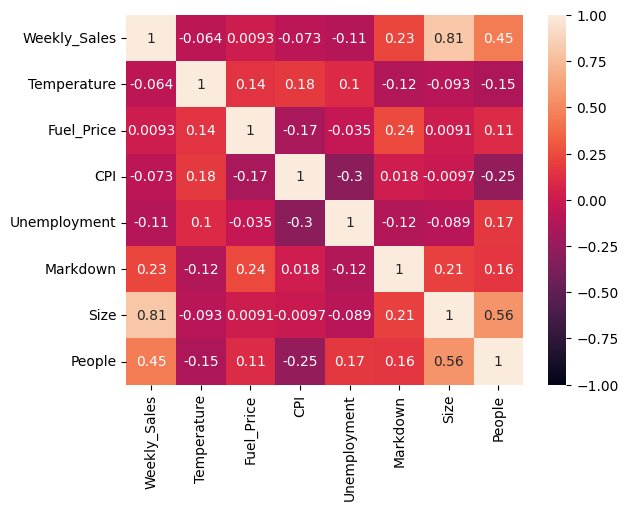

In [40]:
corr = Quanti.corr()
sns.heatmap(corr, vmin=-1, vmax=1,annot=True)

> 5.1 Donner la valeur de corrélation entre `Weekly_Sales` et `Size`. 

> 5.2 Donner la valeur de corrélationentre `Weekly_Sales` et `Unemployment`. 

> 5.3 Donner la valeur de corrélation entre `CPI` et `Fuel_prize`. 

### 5.2 Dépendances entre variables quantitatives et qualitatives

Tracer les boxplots entre les ventes `Weekly_Sales` et le type `Type` de magasin.

<AxesSubplot: xlabel='Weekly_Sales', ylabel='Type'>

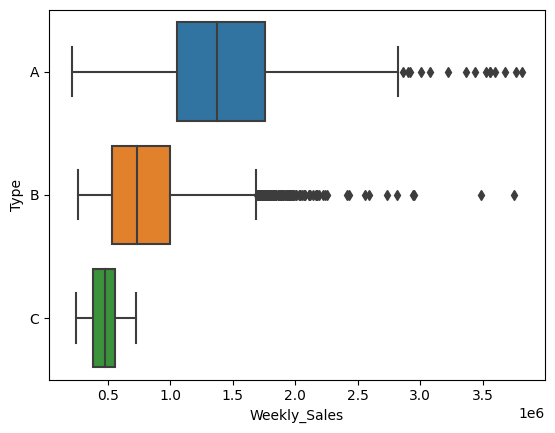

In [41]:
sns.boxplot(x=df2["Weekly_Sales"], y=df2["Type"])

> 5.4  Quel est, approximativement (et en millions), le 3e quartile pour les ventes des magasins de type B ? 1.5, 1, 0.75, 0.5 ?

In [42]:
1

1

> 5.5 Quelle est approximativement la médiane des ventes des magasins de type A ? 2, 1.5, 1, 0.75, 0.5 ?

In [43]:
1.5

1.5

> 5.6 Tracer les boxplots de la taille des magasins en fonction du type de ceux-ci. Quelle est approximativement la médiane de la taille des magasins pour le type B ? [175000, 150000, 120000, 100000] 

<AxesSubplot: xlabel='Size', ylabel='Type'>

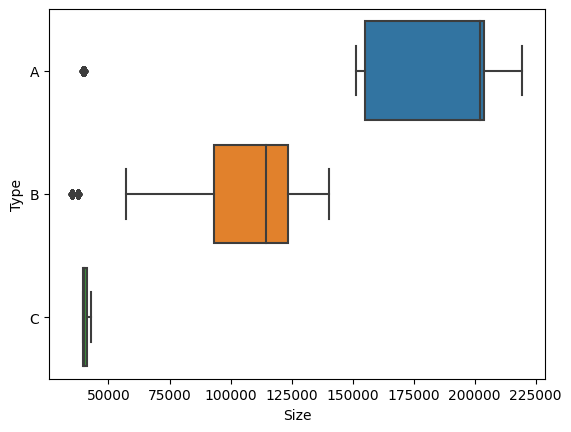

In [44]:
sns.boxplot(x=df2["Size"],y = df2["Type"])

> 5.7 Que penser de la relation entre taille et type ? [Dépendance importante, un peu de corrélation, quasi indépendante]

In [46]:
Importante

NameError: name 'Importante' is not defined

> 5.8 Tracer le boxplot de `Weekly_Sales` en fonction de `IsHoliday`. Que penser de la dépendance entre les ventes et `IsHoliday` [Forte dépendance, dépendance modérée, dépendance faible, pas de dépendance]

In [47]:
sns.boxplot(x=df2["Weekly_Sales"],y = df2["IsHoliday"])


KeyboardInterrupt

Error in callback <function flush_figures at 0x7f317a8c4670> (for post_execute):


KeyboardInterrupt: 

<AxesSubplot: xlabel='IsHoliday', ylabel='Weekly_Sales'>

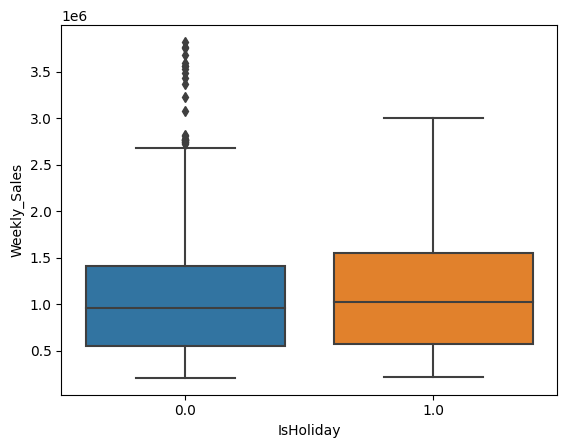

In [48]:
sns.boxplot(x=df2["IsHoliday"],y = df2["Weekly_Sales"])

### 5.3 - Analyse temporelle

> 5.3.1 Tracer l'évolution des ventes au cours du temps. Pour cela, on pourrait tracer magasin par magasin (en extrayant les données correspondantes). Une autre option serait de tracer l'évolution de la moyenne des ventes (sur l'ensemble des magasins), au cours du temps. C'est cette 2e solution qui est utilisée dans `sns.lineplot(...)` que l'on va mettre en oeuvre ici. 

> Utiliser `sns.lineplot`, avec les paramètres corrects, pour tracer l'évolution moyenne des ventes au cours du temps.


<AxesSubplot: xlabel='Date', ylabel='Weekly_Sales'>

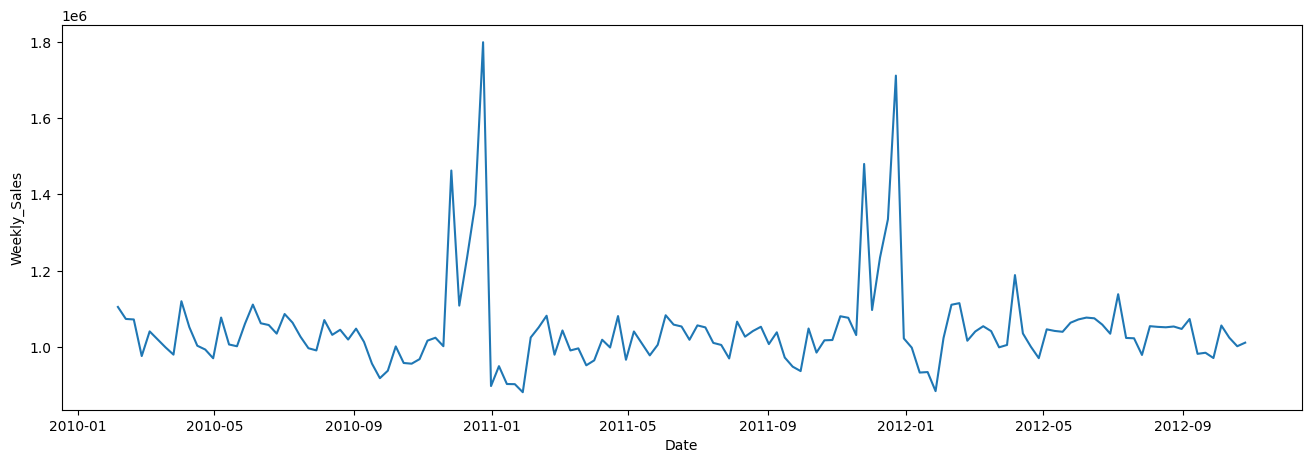

In [49]:
f, ax = plt.subplots(figsize=(16,5))
a = df2.groupby("Date")["Weekly_Sales"].mean()
sns.lineplot(x=a.index, y=a,  ax=ax)

<AxesSubplot: xlabel='Date', ylabel='Weekly_Sales'>

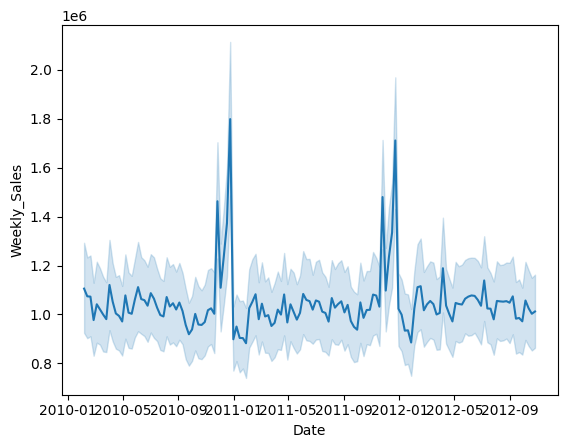

In [50]:
sns.lineplot(data=df2, x="Date", y="Weekly_Sales")

5.3.2 Que penser de l'évolution des ventes au cours de l'année ? [Baisse des ventes en été, Ventes constantes mis à part le week-end, Augmentation des ventes lors des fêtes de fin d'année, grosse ventes en janvier (soldes)]

Grosse hausse pour période de Noël

## 6 - Encodage des variables


### 6.1 Normalisation
> Nous allons utiliser plus loin une régression linéaire afin d'essayer de prédire les ventes. Est-il utile de standardiser les données ? [oui, non]. Si c'est utile, refaites le, comme déjà effectué au moment de l'imputation. 

**Variables qualitatives**

In [0]:
sc = StandardScaler()
sc.fit_transform(df2[quanti])

In [0]:
df2[quanti]=sc.fit_transform(df2[quanti])

### 6.2 Encodage date

> Il nous faut encoder les variables qualitatives. Parmi celles-ci un cas particulier avec la date, que nous pouvons retravailler afin de faire apparaitre jours, mois et années. On le fait pour vous.

In [0]:
dfDate = pd.DataFrame()
dfDate['Year']=df2['Date'].dt.year
dfDate['Month']=df2['Date'].dt.month
dfDate['Week']=df2['Date'].dt.isocalendar().week
dfDate['Day']=df2['Date'].dt.day

### 6.4 Encodage OHE 

>Encoder les 3 autres variables qualitatives en one Hot. Vous pourrez utiliser soit le OneHotEncoder de sklearn, soit la méthode `pd.get_dummies` de pandas

In [0]:
df2['Store'] = df2['Store'].astype('category')   ## par précaution. Sinon il ne le reconnait pas forcément comme une catégorie

In [0]:
Quali = pd.get_dummies(df2[quali])

## 7 - Régression linéaire

### 7.1 Définir une petite fonction qui :
- recevant un dataframe df, le nom de la variable à prédire, la taille de l'ensemble de test, retourne
    - le modèle calculé sur l'ensemble des données
    - le RSS, le RSE (sur l'ensemble d'apprentissage)
    - le R2 sur l'ensemble d'apprentissage, sur l'ensemble de test

In [0]:
def my_linear_regression(df, variable_a_predire, test_size=0.2, seed=SEED):
    #
    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import train_test_split
    X = df.drop(variable_a_predire, axis=1)
    y = df[variable_a_predire]
    p = X.shape[1] #ordre du modèle
    Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=test_size,random_state=SEED)
    Ntrain = Xtrain.shape[0] # taille de l'ensemble d'apprentissage
    model = LinearRegression()

    model.fit(X, y) # fit du modèle retourné sur l'ensemble des données
    ytrain_pred = model.predict(Xtrain)

    RSS = np.sum((ytrain - ytrain_pred) ** 2)
    RSE = np.sqrt(RSS / (Ntrain - p - 1))
    # Calcul du R2 sur l'ensemble d'apprentissage
    TSS = np.sum((ytrain - np.mean(ytrain)) ** 2)
    
    R2app = 1 - RSS / TSS
    ytest_pred = model.predict(Xtest)
    RSS_test = np.sum((ytest - ytest_pred) ** 2)
    TSS_test = np.sum((ytest - np.mean(ytest)) ** 2)
    R2test = 1 - RSS_test / TSS_test


    return model, RSS, RSE, R2app, R2test

### 7.2 Vous cherchez donc à prédire `Weekly_Sales`. 

> Essayons cette prédiction uniquement à partir des données quantitatives (tableau `Quanti`), et avec une taille `test_size` de 0.2. 


In [0]:
model, RSS, RSE, R2app, R2test = my_linear_regression(Quanti, "Weekly_Sales")
print("R2 sur la base d'apprentissage", R2app)
print("R2 sur la base de test", R2test)

> Donner la valeur du R2 sur la base d'apprentissage, sur la base de test

### 7.3 Construire maintenant un nouveau tableau, `data`, 
> qui regroupe ces variables quantitatives, le tableau `dfDate`  issu de la date, et les variables qualitatives issues de l'encodage OHE `Quali`. Vous utiliserez la méthode `pd.concat`

In [0]:
data = pd.concat([dfDate, Quali, Quanti], axis=1)

In [0]:
data.head()

Combien ce nouveau tableau contient-il de colonnes ?

### 7.4 Effectuer la régression linéaire 
> avec ces dernières données. Donner la valeur du R2 sur la base d'apprentissage, sur la base de test

In [0]:
data[["Year", "Month", "Week", "Day"]] = data[["Year", "Month", "Week", "Day"]].fillna(method='ffill')
data.isna().sum().sum()

In [0]:
model, RSS, RSE, R2app, R2test = my_linear_regression(data, "Weekly_Sales")
print("R2 sur la base d'apprentissage", R2app)
print("R2 sur la base de test", R2test)

## 8 - Feature engineering final

Comme on l'a vu, il semble que les fêtes de fin d'année aient une influence sensible sur les ventes. Le graphique suivant, tracé cette fois en fonction des semaines, le montre à nouveau. 

In [0]:
data['Weekly_Sales'] = data['Weekly_Sales'].astype(np.float64)
data['Week'] = data['Week'].astype(np.float64)

In [0]:
f, ax = plt.subplots(figsize=(16,5))
sns.lineplot(x='Week', y='Weekly_Sales',  data=data, ax=ax)
_ = ax.set_xticks(range(1,53))
plt.grid()

> ### 8.1 Définir une variable 'End_of_year_holidays' 
> qui encode cette période. L'optimum étant sans doute que cette variable vaille 1 pour les semaines 47, 49, 50 et 51 et 0 sinon.


In [0]:
data['End_of_year_holidays'] = data["Week"]>=47
data['End_of_year_holidays'] = data['End_of_year_holidays'].replace({True:1, False:0}) 

In [0]:
data[data["Week"]>=46.0]

> ### 8.2 Tester votre régression linéaire 
> A l'aide de ce dernier modèle, donner la valeur du R2 sur la base d'apprentissage et sur la base de test.

In [0]:
model, RSS, RSE, R2app, R2test = my_linear_regression(data, "Weekly_Sales")

In [0]:
print("R2 sur la base d'apprentissage", R2app)
print("R2 sur la base de test", R2test)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=db9545f6-8002-46cd-a484-5acdd64b9574' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>